In [1]:
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 8

# the mean and std are the calculated statistics from cifar_10 dataset
cifar_10_mean = (0.491, 0.482, 0.447) # mean for the three channels of cifar_10 images
cifar_10_std = (0.202, 0.199, 0.201) # std for the three channels of cifar_10 images

mean = torch.tensor(cifar_10_mean).to(device).view(3, 1, 1)
std = torch.tensor(cifar_10_std).to(device).view(3, 1, 1)

epsilon = 8 / 255 / std

alpha = 0.8 / 255 / std

root = './data'

In [2]:
import os
import glob
import shutil
import numpy as np
from PIL import Image
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_10_mean, cifar_10_std)
])

class AdvDataset(Dataset):
    def __init__(self, data_dir, transform):
        self.images = []
        self.labels = []
        self.names = []
        
        for i, class_dir in enumerate(sorted(glob.glob(f'{data_dir}/*'))):
            images = sorted(glob.glob(f'{class_dir}/*'))
            self.images += images
            self.labels += ([i] * len(images))
        
        self.names = [os.path.relpath(img, data_dir) for img in self.images]
        self.transform = transform
    
    def __getitem__(self, idx):
        image = self.transform(Image.open(self.images[idx]))
        label = self.labels[idx]
        return image, label
    
    def __getname__(self):
        return self.names
    
    def __len__(self):
        return len(self.images)

adv_set = AdvDataset(root, transform)
adv_names = adv_set.__getname__()
adv_loader = DataLoader(adv_set, batch_size=batch_size, shuffle=False)

print(f'number of images = {adv_set.__len__()}')

number of images = 200


In [3]:
def epoch_benign(model, loader, loss_fn):
    model.eval()
    train_acc, train_loss = 0.0, 0.0
    for img, label in loader:
        img, label = img.to(device), label.to(device)
        pre = model(img)
        loss = loss_fn(pre, label)
        train_loss += loss.item() * img.shape[0]
        train_acc += (pre.argmax(dim=1) == label).sum().item()
    
    return train_acc / len(loader.dataset), train_loss / len(loader.dataset)

In [4]:
def fgsm(model, x, y, loss_fn, epsilon=epsilon):
    x_adv = x.detach().clone()
    x_adv.requires_grad = True
    loss = loss_fn(model(x_adv), y)
    loss.backward()
    x_adv = x_adv + epsilon * x_adv.grad.detach().sign()
    return x_adv

In [5]:
def ifgsm(model, x, y, loss_fn, alpha=alpha, epsilon=epsilon, num_iter=20):
    x_adv = x.detach().clone()
    for i in range(num_iter):
        x_adv = fgsm(model, x_adv, y, loss_fn, alpha)
        x_adv = torch.min(torch.max(x_adv, x - epsilon), x + epsilon)
    
    return x_adv

In [6]:
def gen_adv_examples(model, loader, attack, loss_fn):
    model.eval()
    train_loss, train_acc = 0.0, 0.0
    for i, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        x_adv = attack(model, x, y, loss_fn)
        yp = model(x_adv)
        loss = loss_fn(yp, y)
        train_loss += loss.item() * x.shape[0]
        train_acc += (yp.argmax(dim=1) == y).sum().item()
        adv_ex = (x_adv * std + mean).clamp(0, 1)
        adv_ex = (adv_ex * 255).clamp(0, 255)
        adv_ex = adv_ex.detach().cpu().data.numpy().round()
        adv_ex = adv_ex.transpose((0, 2, 3, 1))
        adv_examples = adv_ex if i == 0 else np.r_[adv_examples, adv_ex]
    
    return adv_examples, train_acc / len(loader.dataset), train_loss / len(loader.dataset)

In [7]:
def create_dir(data_dir, adv_dir, adv_examples, adv_names):
    if os.path.exists(adv_dir) is not True:
        _ = shutil.copytree(data_dir, adv_dir)
    for ex, name in zip(adv_examples, adv_names):
        im = Image.fromarray(ex.astype(np.uint8))
        im.save(os.path.join(adv_dir, name))

In [8]:
from pytorchcv.model_provider import get_model as ptcv_get_model

model = ptcv_get_model('resnet110_cifar10', pretrained=True).to(device)
loss_fn = nn.CrossEntropyLoss()
benign_acc, benign_loss = epoch_benign(model, adv_loader, loss_fn)
print(f'benign_acc = {benign_acc:.5f}, benign_loss = {benign_loss:.5f}')

benign_acc = 0.95000, benign_loss = 0.22683


In [8]:
from pytorchcv.model_provider import get_model as ptcv_get_model

class FusionEnsemble(nn.Module):
    def __init__(self, model_lists):
        super(FusionEnsemble, self).__init__()
        self.models = []
        for i in range(15):
            self.models.append(ptcv_get_model(model_lists[i], pretrained=True).to(device))
    
    def forward(self, x):
        for i, model in enumerate(self.models):
            if i == 0:
                y = model(x.clone())
            else:
                y += model(x.clone())
        
        return y / len(self.models)

In [9]:
model_lists = ['resnext29_16x64d_cifar10','resnext29_32x4d_cifar10','preresnet56_cifar10','preresnet110_cifar10',
               'preresnet164bn_cifar10','seresnet110_cifar10','sepreresnet56_cifar10','sepreresnet110_cifar10',
               'diaresnet56_cifar10','resnet1001_cifar10','diapreresnet56_cifar10','resnet1202_cifar10',
               'resnet56_cifar10','resnet110_cifar10','diapreresnet110_cifar10']
model = FusionEnsemble(model_lists).to(device)
loss_fn = nn.CrossEntropyLoss()
benign_acc, benign_loss = epoch_benign(model, adv_loader, loss_fn)
print(f'benign_acc = {benign_acc:.5f}, benign_loss = {benign_loss:.5f}')

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 4.00 GiB total capacity; 1.95 GiB already allocated; 0 bytes free; 1.95 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [9]:
adv_examples, fgsm_acc, fgsm_loss = gen_adv_examples(model, adv_loader, fgsm, loss_fn)

print(f'fgsm_acc = {fgsm_acc:.5f}, fgsm_loss = {fgsm_loss:.5f}')

create_dir(root, 'fgsm', adv_examples, adv_names)

fgsm_acc = 0.60000, fgsm_loss = 2.49475


In [10]:
adv_examples, ifgsm_acc, ifgsm_loss = gen_adv_examples(model, adv_loader, ifgsm, loss_fn)

print(f'ifgsm_acc = {ifgsm_acc:.5f}, ifgsm_loss = {ifgsm_loss:.5f}')

create_dir(root, 'ifgsm', adv_examples, adv_names)

ifgsm_acc = 0.00500, ifgsm_loss = 17.67385


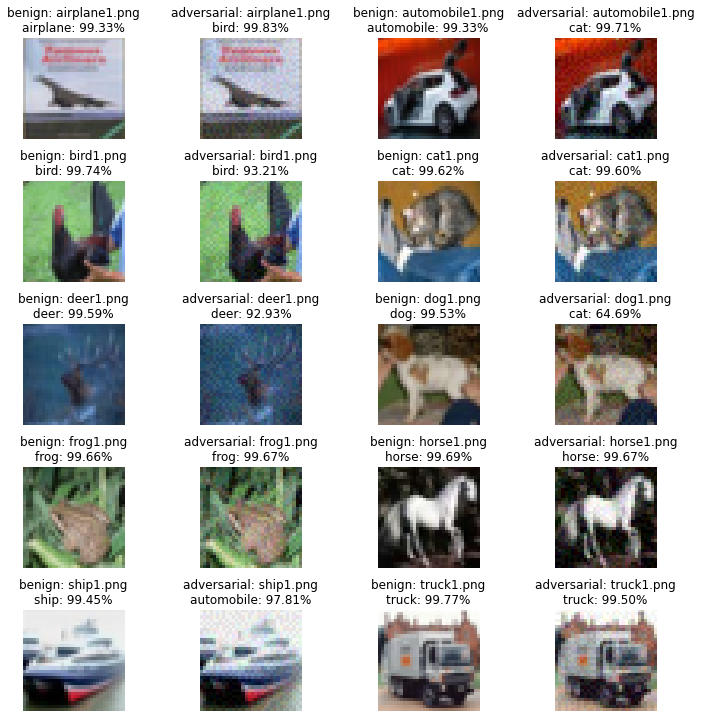

In [60]:
import matplotlib.pyplot as plt

cnt = 0
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(10, 20))
for i, cls_name in enumerate(classes):
    cnt += 1
    path = f'./data/{cls_name}/{cls_name}1.png'
    plt.subplot(len(classes), 4, cnt)
    im = Image.open(path)
    logit = model(transform(im).unsqueeze(0).to(device))[0]
    cls = logit.argmax(dim=-1).item()
    prob = logit.softmax(dim=-1)[cls].item()
    plt.title(f'benign: {cls_name}1.png\n{classes[cls]}: {prob:.2%}')
    plt.axis('off')
    plt.imshow(np.array(im))
    
    cnt += 1
    plt.subplot(len(classes), 4, cnt)
    path = f'./fgsm/{cls_name}/{cls_name}1.png'
    im = Image.open(path)
    logit = model(transform(im).unsqueeze(0).to(device))[0]
    cls = logit.argmax(dim=-1).item()
    prob = logit.softmax(dim=-1)[cls].item()
    plt.title(f'adversarial: {cls_name}1.png\n{classes[cls]}: {prob:.2%}')
    plt.axis('off')
    plt.imshow(np.array(im))

plt.tight_layout()
plt.show()

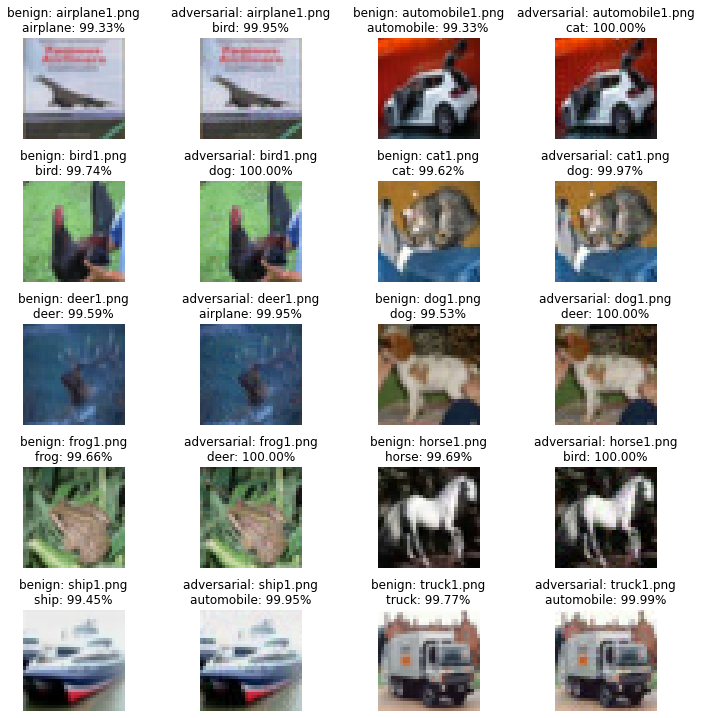

In [61]:
import matplotlib.pyplot as plt

cnt = 0
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(10, 20))
for i, cls_name in enumerate(classes):
    cnt += 1
    path = f'./data/{cls_name}/{cls_name}1.png'
    plt.subplot(len(classes), 4, cnt)
    im = Image.open(path)
    logit = model(transform(im).unsqueeze(0).to(device))[0]
    cls = logit.argmax(dim=-1).item()
    prob = logit.softmax(dim=-1)[cls].item()
    plt.title(f'benign: {cls_name}1.png\n{classes[cls]}: {prob:.2%}')
    plt.axis('off')
    plt.imshow(np.array(im))
    
    cnt += 1
    plt.subplot(len(classes), 4, cnt)
    path = f'./ifgsm/{cls_name}/{cls_name}1.png'
    im = Image.open(path)
    logit = model(transform(im).unsqueeze(0).to(device))[0]
    cls = logit.argmax(dim=-1).item()
    prob = logit.softmax(dim=-1)[cls].item()
    plt.title(f'adversarial: {cls_name}1.png\n{classes[cls]}: {prob:.2%}')
    plt.axis('off')
    plt.imshow(np.array(im))

plt.tight_layout()
plt.show()